In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
data = json.load(open("SFdata//604.json"))

pixscale = 0.26 # arcsec
pixscale *= 4.09                   # parsec
s0 = 4.09/2.355                    # parsec
m = 1.6

In [4]:
r = pixscale * 10**np.array(data["log10 r"])
rgrid = pixscale * np.logspace(0.0, 2)

B = np.array(data["Unweighted B(r)"])

sig2 = data["Unweighted sigma^2"]
r0 = np.interp(sig2, B, r)

54.62045699825188

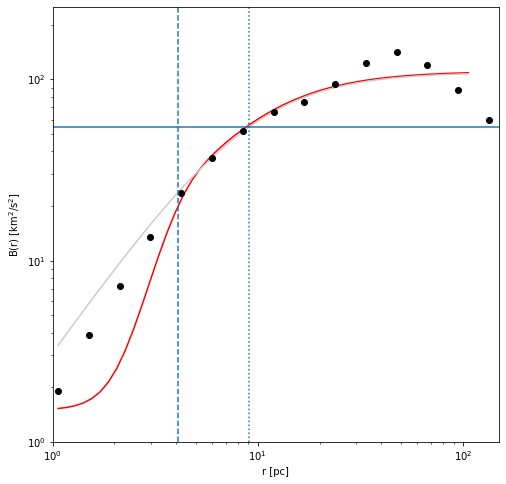

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc02(rgrid, r0, sig2, m, s0, 1.5), color="red")
ax.plot(rgrid, bfunc00(rgrid, r0, sig2, m), color="0.8")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.axhline(sig2)
ax.axvline(2.355 * s0, linestyle="dashed")
ax.axvline(r0, linestyle="dotted")

ax.set(
    xscale = "log",
    yscale = "log",
    ylim  = [1, 250],
    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

sig2

In [6]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [7]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 3.3

In [8]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=1.0)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2    54.6205        0      inf    False    


In [9]:
result2 = model02.fit(
    B, 
    weights=weights,
    r=r, r0=r0, m=m, s0=s0, noise=1.0,
)

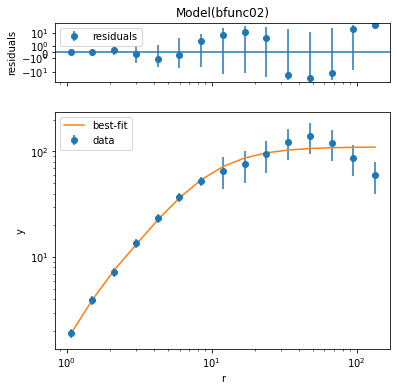

In [10]:
fig, _ = result2.plot()
fig.axes[0].set(
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale="log",
    yscale="log",
);

In [11]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 86
    # data points      = 15
    # variables        = 4
    chi-square         = 8.97753891
    reduced chi-square = 0.81613990
    Akaike info crit   = 0.30013371
    Bayesian info crit = 3.13233451
[[Variables]]
    r0:     8.75224905 +/- 0.54147657 (6.19%) (init = 9.091583)
    sig2:   54.62046 (fixed)
    m:      1.95608871 +/- 0.11966680 (6.12%) (init = 1.6)
    s0:     0.60449376 +/- 0.15735523 (26.03%) (init = 1.73673)
    noise:  1.14775901 +/- 0.61103102 (53.24%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise) =  0.919
    C(r0, m)     = -0.830
    C(r0, s0)    =  0.410
    C(r0, noise) =  0.261
    C(m, s0)     = -0.218


In [12]:
#for p in result2.model.param_names:
#    result2.params[p].stderr = result2.params[p].value * 0.1

In [13]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(s0=0.44713853592889097) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(noise=0.5367279918308262) = 0.0 < max(sigmas).
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -1.57603  -1.10365  -0.72860   8.75225  +0.68836  +1.74798  +4.38226
 m    :  -0.72999  -0.34669  -0.14216   1.95609  +0.12638  +0.27618  +0.48671
 s0   :      -inf      -inf      -inf   0.60449  +0.16535  +0.33969  +0.60539
 noise:      -inf      -inf      -inf   1.14776  +0.49262  +0.84023  +1.21474


In [14]:
plt.style.use([
    "seaborn-poster",
])

In [15]:
plot_limits = {
    "s0": [0.0, 1.5],
    "m": [0.5, 3],
    "r0": [5.0, 16.0],
    "noise": [0.0, 4.0],
}

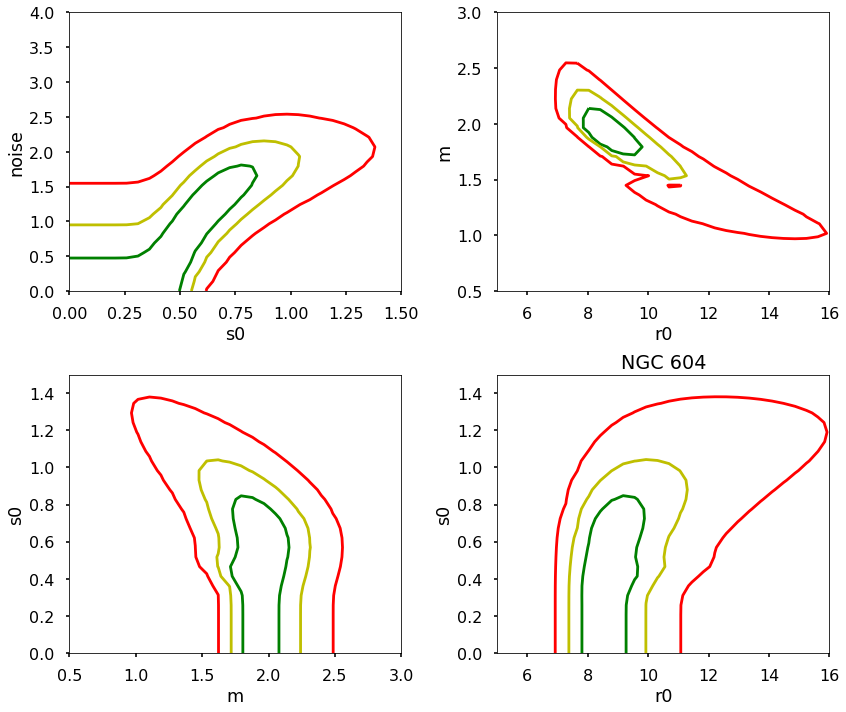

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('NGC 604')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [17]:
result2

In [18]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 58.255399227142334 seconds ---
